<a href="https://colab.research.google.com/github/mehrnazeraeisi/Cookie_Recipes/blob/main/Cookie_Recipes_knnregression_modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#[1]
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.model_selection import train_test_split


In [4]:

# Function to prioritize features based on KNN R² score
def features_prioritization(X, y, features):
    features_scores = []
    knn_reg = KNeighborsRegressor()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_reg.fit(X_feature, y)
        y_pred = knn_reg.predict(X_feature)
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        features_scores.append((feature, r2, mse))  # اضافه شد

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'R2_Score', 'MSE']).sort_values(by='R2_Score', ascending=False)
    return df_scores


In [5]:
# بارگذاری فایل اکسل
data = pd.read_csv('cookie_recipes.csv')

print(data.columns)
# نمایش اطلاعات
print(data.head())
data.shape


Index(['flour', 'butter', 'eggs', 'soda', 'chips', 'rating'], dtype='object')
   flour  butter  eggs  soda  chips  rating
0   2.50       6     3     3   0.75    1.25
1   2.25      10     1     3   1.25    2.50
2   1.50      10     3     4   1.25    3.50
3   1.50      10     3     1   0.75    2.75
4   1.50      10     3     3   0.75    2.75


(50, 6)

In [6]:

# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('rating', axis=1)
y_data = data['rating']
data_features = X_data.columns       # نام ویژگی‌ها




In [7]:
# Run feature prioritization for the iris dataset
data_scores = features_prioritization(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (cookie_recipes dataset):")
print(data_scores)  # Categorize features by R² score

🔎 Feature Group Performance Summary (cookie_recipes dataset):
  Feature  R2_Score     MSE
4   chips  0.563751  0.5950
0   flour  0.512941  0.6643
3    soda -0.018843  1.3896
2    eggs -0.037246  1.4147
1  butter -0.045898  1.4265


In [11]:
# Categorizing features by R² score into multiple levels
strong_features = data_scores[data_scores['R2_Score'] > 0.5]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['R2_Score'] > -0.02)]['Feature'].tolist()
medium_features_2 = data_scores[(data_scores['R2_Score'] > -0.04)]['Feature'].tolist()
medium_features_3 = data_scores[(data_scores['R2_Score'] > -0.05)]['Feature'].tolist()


In [12]:
# Function to safely compute KNN R² score for feature group

def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:  # اصلاح این خط
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    return model.score(X_subset, y_data)

In [13]:

# Function to prioritize features based on KNN MSE

def knn_mse(X_data, y_data, selected_features):
    if len(selected_features) == 0:
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    y_pred = model.predict(X_subset)
    return mean_squared_error(y_data, y_pred)

In [14]:

#[8]
# Compute R² and accuracy scores for each group
groups = [data_features, strong_features, medium_features_1, medium_features_2, medium_features_3]

r2_scores = [knn_score(X_data, y_data, group) for group in groups]
mse_scores = [knn_mse(X_data, y_data, group) for group in groups]


In [15]:
# Build summary DataFrame
summary_df = pd.DataFrame({
    'Feature_Group': ['all Features', 'Strong Features', 'Medium Features_1 (0.7-0.8)', 'Medium Features_2 (0.6-0.7)',
                      'Medium Features_3 (0.5-0.6)'],
    'R2_Score': r2_scores,
    'MSE':mse_scores

})

print("\n📊 Grouped Feature Performance Summary (R² and Accuracy):")
print(summary_df)



📊 Grouped Feature Performance Summary (R² and Accuracy):
                 Feature_Group  R2_Score      MSE
0                 All Features  0.450546  0.74940
1              Strong Features  0.971479  0.03890
2  Medium Features_1 (0.7-0.8)  0.903989  0.13095
3  Medium Features_2 (0.6-0.7)  0.668781  0.45175
4  Medium Features_3 (0.5-0.6)  0.450546  0.74940


In [19]:

def knn_evaluation(X_data, y_data,strong_features ,  data_features, test_size, n_repeats):
    # Initialize lists to store the results
    mse_scores = {
        "all features": [],
        "strong_features": []
    }

    r2_scores = {
        "all features": [],
        "strong_features":[]
    }


    # List of feature groups to evaluate
    feature_groups = {
        "all features": data_features,
        "strong_features": strong_features
    }

    # Repeat the process n_repeats times with different train-test splits
    for _ in range(n_repeats):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # KNN Regressor
            knn_reg = KNeighborsRegressor(n_neighbors=5)
            knn_reg.fit(X_train[group_features], y_train)
            y_pred_reg = knn_reg.predict(X_test[group_features])
            r2_scores[group_name].append(r2_score(y_test, y_pred_reg))
            mse_scores[group_name].append(mean_squared_error(y_test, y_pred_reg))

    # Plot results for R² and Accuracy
    x = np.arange(1, n_repeats + 1)


    # R² plot
    plt.figure( figsize=(8, 6))
    for group_name, r2_list in r2_scores.items():
        plt.plot(x, r2_list, label=f"{group_name.replace('_', ' ').title()} R²", marker='x')
    plt.xlabel('Repeat')
    plt.ylabel('R² Score')
    plt.title('KNN Regressor Performance')
    plt.legend()
    plt.show()


    # MSE plot
    plt.figure(figsize=(8, 6))
    for group_name, mse_list in mse_scores.items():
        plt.plot(x, mse_list, label=f"{group_name.replace('_', ' ').title()} MSE", marker='s')
    plt.xlabel('Repeat')
    plt.ylabel('Mean Squared Error')
    plt.title('KNN Regressor MSE Performance')
    plt.legend()
    plt.show()



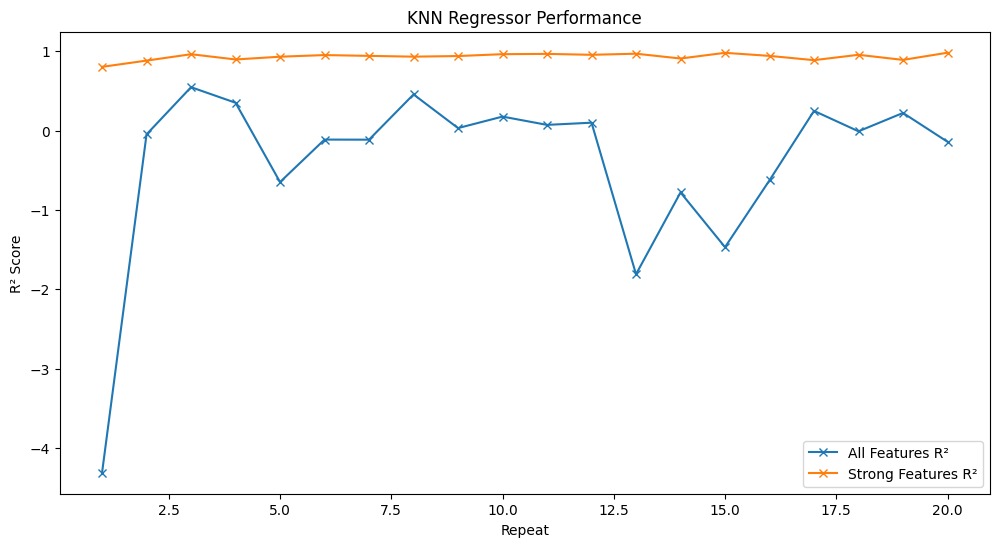

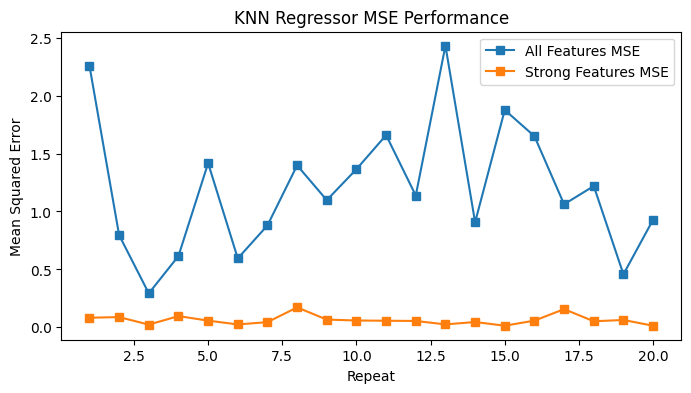

In [21]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, strong_features, data_features, test_size=0.1, n_repeats=20)


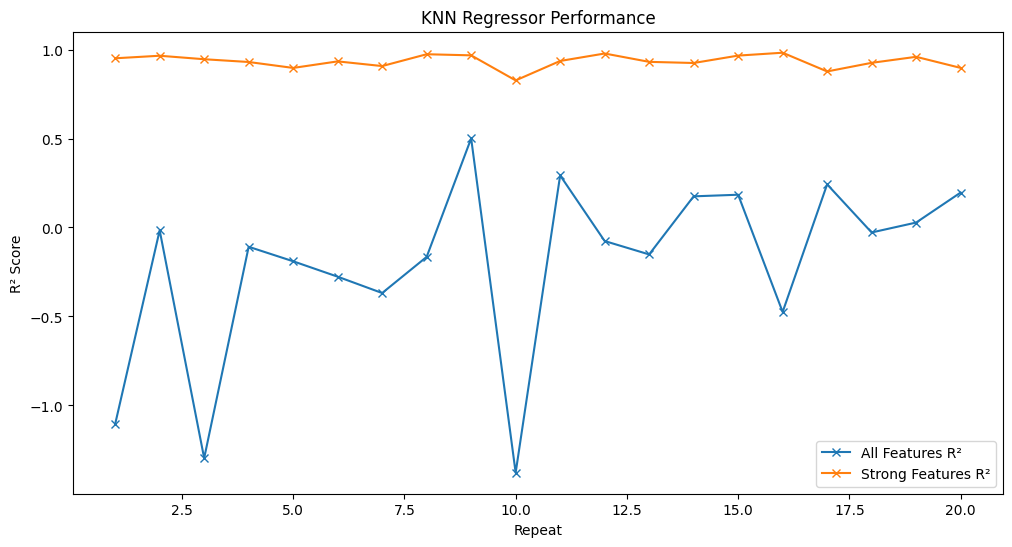

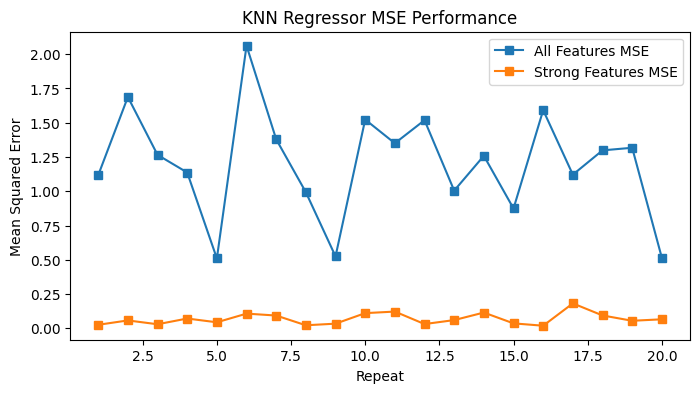

In [22]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, strong_features,  data_features, test_size=0.13, n_repeats=20)


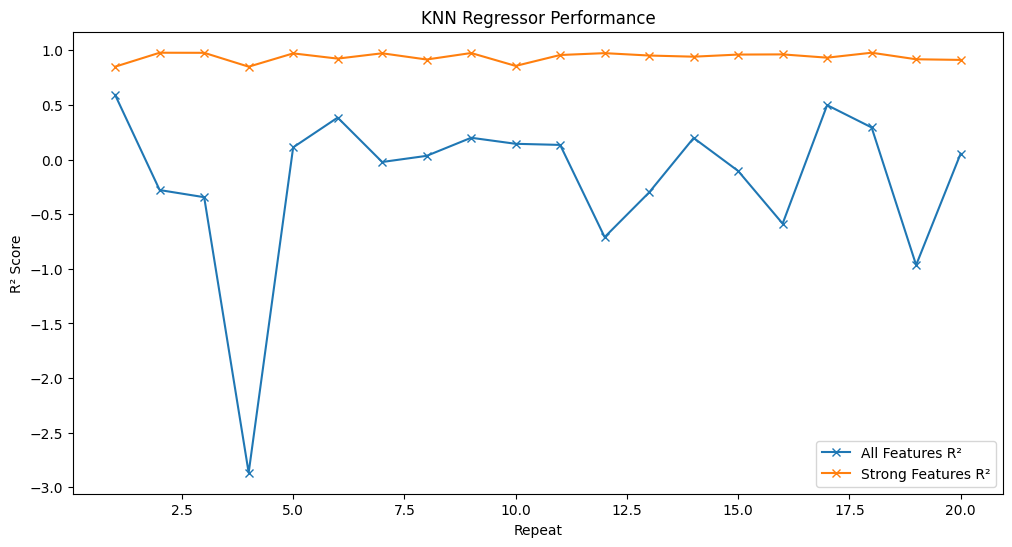

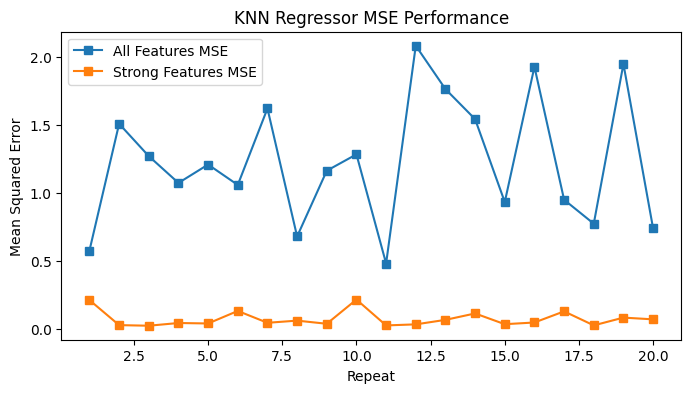

In [23]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, strong_features,  data_features, test_size=0.16, n_repeats=20)


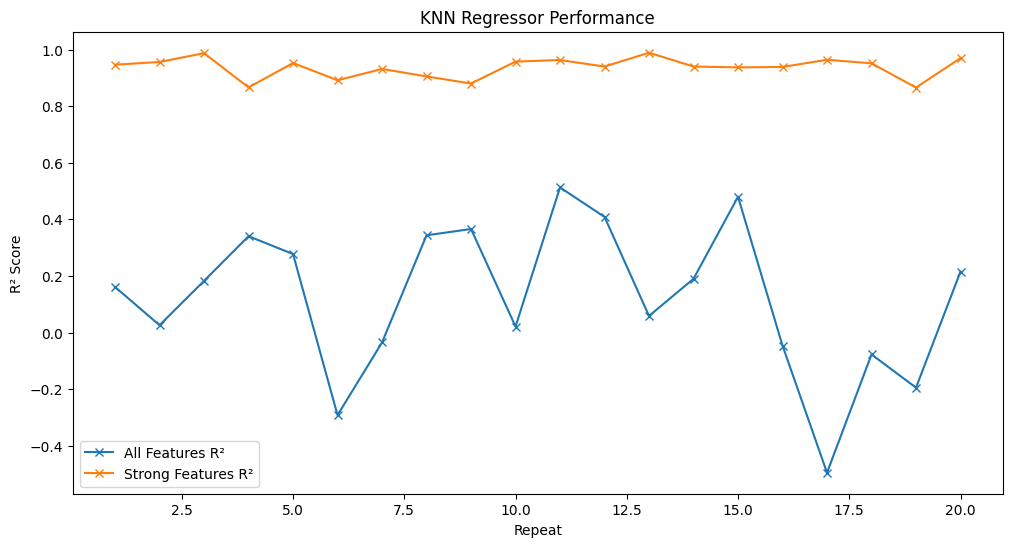

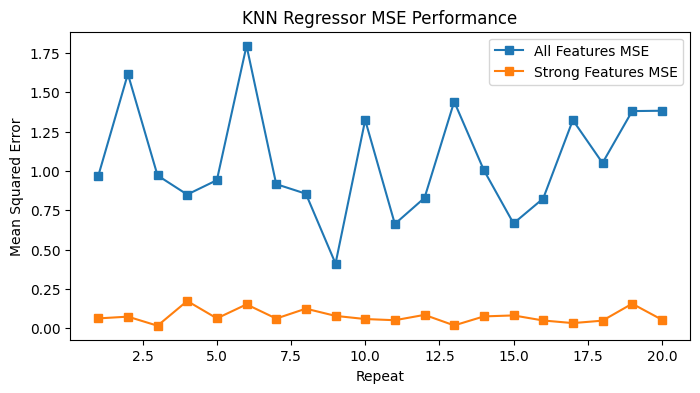

In [24]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, strong_features,  data_features, test_size=0.19, n_repeats=20)


In [26]:
def knn_evaluation_table(X_data, y_data,  strong_features, data_features, test_sizes, n_repeats):
    results = []

    feature_groups = {
        "All": data_features,
        "strong_features": strong_features
    }

    for test_size in test_sizes:
        for i in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

            # محاسبه برای همه ویژگی‌ها
            knn_reg_all = KNeighborsRegressor(n_neighbors=5)
            knn_reg_all.fit(X_train[feature_groups["All"]], y_train)
            y_pred_all = knn_reg_all.predict(X_test[feature_groups["All"]])
            mse_all = mean_squared_error(y_test, y_pred_all)
            r2_all = r2_score(y_test, y_pred_all)

            # محاسبه برای ویژگی‌های متوسط
            knn_reg_modified = KNeighborsRegressor(n_neighbors=5)
            knn_reg_modified.fit(X_train[feature_groups["strong_features"]], y_train)
            y_pred_modified = knn_reg_modified.predict(X_test[feature_groups["strong_features"]])
            mse_modified = mean_squared_error(y_test, y_pred_modified)
            r2_modified = r2_score(y_test, y_pred_modified)

            # ذخیره در لیست
            results.append({
                "Percentage": f"{int(test_size * 100)}%",
                "Repetition": f"n={i}",
                "MSE_All": mse_all,
                "R2_All": r2_all,
                "MSE_Modified": mse_modified,
                "R2_Modified": r2_modified
            })

    # ساخت دیتافریم خروجی
    df_result = pd.DataFrame(results)
    return df_result


# درصدهای تست مختلف
test_sizes = [0.10, 0.13, 0.16, 0.19, 0.25]
n_repeats = 20

# اجرای ارزیابی و دریافت جدول
final_df = knn_evaluation_table(X_data, y_data,  strong_features, data_features, test_sizes, n_repeats)

# نمایش جدول
print(final_df)

# (اختیاری) ذخیره جدول در فایل اکسل یا CSV
# final_df.to_csv("knn_results_table.csv", index=False)


   Percentage Repetition   MSE_All    R2_All  MSE_Modified  R2_Modified
0         10%        n=1  0.985500  0.150431      0.087000     0.925000
1         10%        n=2  0.227000  0.484091      0.118500     0.730682
2         10%        n=3  1.090000 -0.337423      0.023000     0.971779
3         10%        n=4  0.325500  0.491406      0.062000     0.903125
4         10%        n=5  1.033000 -0.444755      0.046500     0.934965
..        ...        ...       ...       ...           ...          ...
95        25%       n=16  1.835385 -0.227221      0.070769     0.952681
96        25%       n=17  1.011346 -0.173682      0.057115     0.933717
97        25%       n=18  1.226923 -0.077843      0.078654     0.930903
98        25%       n=19  0.990000  0.145833      0.103269     0.910900
99        25%       n=20  1.419808 -0.236046      0.040000     0.965177

[100 rows x 6 columns]


Index(['flour', 'butter', 'eggs', 'soda', 'chips', 'rating'], dtype='object')
   flour  butter  eggs  soda  chips  rating
0   2.50       6     3     3   0.75    1.25
1   2.25      10     1     3   1.25    2.50
2   1.50      10     3     4   1.25    3.50
3   1.50      10     3     1   0.75    2.75
4   1.50      10     3     3   0.75    2.75
🔎 Feature Group Performance Summary (Cancer dataset):
  Feature  R2_Score     MSE
4   chips  0.563751  0.5950
0   flour  0.512941  0.6643
3    soda -0.018843  1.3896
2    eggs -0.037246  1.4147
1  butter -0.045898  1.4265

📊 Grouped Feature Performance Summary (R² and MSE):
                 Feature_Group  R2_Score      MSE
0                 all Features  0.450546  0.74940
1              Strong Features  0.971479  0.03890
2  Medium Features_1 (0.7-0.8)  0.903989  0.13095
3  Medium Features_2 (0.6-0.7)  0.668781  0.45175
4  Medium Features_3 (0.5-0.6)  0.450546  0.74940


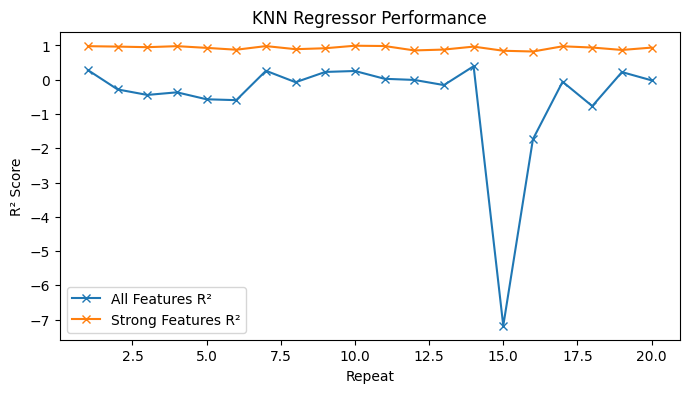

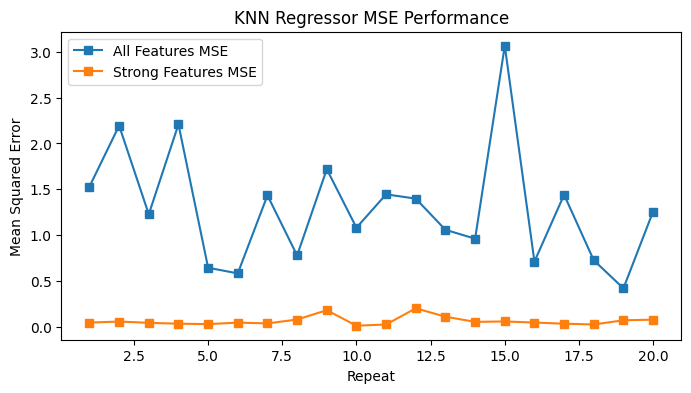

   Percentage Repetition   MSE_All    R2_All  MSE_Modified  R2_Modified
0         10%        n=1  1.172000  0.432446      0.182500     0.911622
1         10%        n=2  0.974000 -1.346988      0.122500     0.704819
2         10%        n=3  1.226000  0.463457      0.153000     0.933042
3         10%        n=4  1.446500 -0.672254      0.047500     0.945087
4         10%        n=5  1.616000 -1.276056      0.102500     0.855634
..        ...        ...       ...       ...           ...          ...
95        25%       n=16  1.269231  0.084312      0.028654     0.979328
96        25%       n=17  1.273269 -0.146112      0.094615     0.914834
97        25%       n=18  1.625000  0.002724      0.068462     0.957985
98        25%       n=19  0.877692 -0.243857      0.069423     0.901614
99        25%       n=20  1.178269 -0.118694      0.048269     0.954171

[100 rows x 6 columns]


In [28]:
#[1]
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.model_selection import train_test_split


# Function to prioritize features based on KNN R² score
def features_prioritization(X, y, features):
    features_scores = []
    knn_reg = KNeighborsRegressor()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_reg.fit(X_feature, y)
        y_pred = knn_reg.predict(X_feature)
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        features_scores.append((feature, r2, mse))  # اضافه شد

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'R2_Score', 'MSE']).sort_values(by='R2_Score', ascending=False)
    return df_scores




# بارگذاری فایل
data = pd.read_csv('cookie_recipes.csv')

print(data.columns)
# نمایش اطلاعات
print(data.head())
data.shape


# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('rating', axis=1)
y_data = data['rating']
data_features = X_data.columns       # نام ویژگی‌ها




#[5]
# Run feature prioritization for the iris dataset
data_scores = features_prioritization(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (Cancer dataset):")
print(data_scores)  # Categorize features by R² score

# Categorizing features by R² score into multiple levels
strong_features = data_scores[data_scores['R2_Score'] > 0.5]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['R2_Score'] > -0.02)]['Feature'].tolist()
medium_features_2 = data_scores[(data_scores['R2_Score'] > -0.04)]['Feature'].tolist()
medium_features_3 = data_scores[(data_scores['R2_Score'] > -0.05)]['Feature'].tolist()


#[7]
# Function to safely compute KNN R² score for feature group

def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:  # اصلاح این خط
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    return model.score(X_subset, y_data)


# Function to prioritize features based on KNN MSE

def knn_mse(X_data, y_data, selected_features):
    if len(selected_features) == 0:
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    y_pred = model.predict(X_subset)
    return mean_squared_error(y_data, y_pred)




#[8]
# Compute R² and accuracy scores for each group
groups = [data_features, strong_features, medium_features_1, medium_features_2, medium_features_3 ]

r2_scores = [knn_score(X_data, y_data, group) for group in groups]
mse_scores = [knn_mse(X_data, y_data, group) for group in groups]

# Build summary DataFrame
summary_df = pd.DataFrame({
    'Feature_Group': ['all Features', 'Strong Features', 'Medium Features_1 (0.7-0.8)', 'Medium Features_2 (0.6-0.7)',
                      'Medium Features_3 (0.5-0.6)'],
    'R2_Score': r2_scores,
    'MSE':mse_scores

})

print("\n📊 Grouped Feature Performance Summary (R² and MSE):")
print(summary_df)




def knn_evaluation(X_data, y_data, strong_features, data_features, test_size, n_repeats):
    # Initialize lists to store the results

    mse_scores = {
        "all_features": [],
        "strong_features": []
    }


    r2_scores = {
        "all_features": [],
        "strong_features": [],
    }

    # List of feature groups to evaluate
    feature_groups = {
        "all_features": data_features,
        "strong_features": strong_features,
    }

    # Repeat the process n_repeats times with different train-test splits
    for _ in range(n_repeats):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # KNN Regressor
            knn_reg = KNeighborsRegressor(n_neighbors=5)
            knn_reg.fit(X_train[group_features], y_train)
            y_pred_reg = knn_reg.predict(X_test[group_features])
            r2_scores[group_name].append(r2_score(y_test, y_pred_reg))
            mse_scores[group_name].append(mean_squared_error(y_test, y_pred_reg))

    # Plot results for R² and Accuracy
    x = np.arange(1, n_repeats + 1)


    # R² plot
    plt.figure( figsize=(8, 4))
    for group_name, r2_list in r2_scores.items():
        plt.plot(x, r2_list, label=f"{group_name.replace('_', ' ').title()} R²", marker='x')
    plt.xlabel('Repeat')
    plt.ylabel('R² Score')
    plt.title('KNN Regressor Performance')
    plt.legend()
    plt.show()

    # MSE plot
    plt.figure(figsize=(8, 4))
    for group_name, mse_list in mse_scores.items():
        plt.plot(x, mse_list, label=f"{group_name.replace('_', ' ').title()} MSE", marker='s')
    plt.xlabel('Repeat')
    plt.ylabel('Mean Squared Error')
    plt.title('KNN Regressor MSE Performance')
    plt.legend()
    plt.show()


# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data,  strong_features, data_features, test_size=0.10, n_repeats=20)



def knn_evaluation_table(X_data, y_data,  strong_features, data_features, test_sizes, n_repeats):
    results = []

    feature_groups = {
        "All": data_features,
        "strong_features": strong_features
    }

    for test_size in test_sizes:
        for i in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

            # محاسبه برای همه ویژگی‌ها
            knn_reg_all = KNeighborsRegressor(n_neighbors=5)
            knn_reg_all.fit(X_train[feature_groups["All"]], y_train)
            y_pred_all = knn_reg_all.predict(X_test[feature_groups["All"]])
            mse_all = mean_squared_error(y_test, y_pred_all)
            r2_all = r2_score(y_test, y_pred_all)

            # محاسبه برای ویژگی‌های متوسط
            knn_reg_modified = KNeighborsRegressor(n_neighbors=5)
            knn_reg_modified.fit(X_train[feature_groups["strong_features"]], y_train)
            y_pred_modified = knn_reg_modified.predict(X_test[feature_groups["strong_features"]])
            mse_modified = mean_squared_error(y_test, y_pred_modified)
            r2_modified = r2_score(y_test, y_pred_modified)

            # ذخیره در لیست
            results.append({
                "Percentage": f"{int(test_size * 100)}%",
                "Repetition": f"n={i}",
                "MSE_All": mse_all,
                "R2_All": r2_all,
                "MSE_Modified": mse_modified,
                "R2_Modified": r2_modified
            })

    # ساخت دیتافریم خروجی
    df_result = pd.DataFrame(results)
    return df_result


# درصدهای تست مختلف
test_sizes = [0.10, 0.13, 0.16, 0.19, 0.25]
n_repeats = 20

# اجرای ارزیابی و دریافت جدول
final_df = knn_evaluation_table(X_data, y_data,  strong_features, data_features, test_sizes, n_repeats)

# نمایش جدول
print(final_df)

# (اختیاری) ذخیره جدول در فایل اکسل یا CSV
# final_df.to_csv("knn_results_table.csv", index=False)
